# **This notebook aims to preprocess dataset and make data engineering**

## Importation of Librairies

In [61]:
%reset -f

In [2]:
!pip install xgboost
!pip install tensorflow
!pip install optuna
!pip install umap


     --------------------------------------- 99.8/99.8 MB 10.9 MB/s eta 0:00:00
     -------------------------------------- 376.9/376.9 MB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 14.2 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
     ------------------------------------- 413.4/413.4 kB 25.2 MB/s eta 0:00:00
  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl (15.8 MB)
     -------------------------------------- 127.7/127.7 kB 7.8 MB/s eta 0:00:00
     --------------------------------------- 26.4/26.4 MB 14.2 MB/s eta 0:00:00
     ---------------------------------------- 3.0/3.0 MB 14.6 MB/s eta 0:00:00
     ---------------------------------------- 3.9/3.9 MB 13.8 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 13.0 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 13.5 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.2.2 requires pyqt5<5.13, which is not installed.
spyder 5.2.2 requires pyqtwebengine<5.13, which is not installed.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.26.4 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.26.4 which is incompatible.


     -------------------------------------- 380.1/380.1 kB 6.0 MB/s eta 0:00:00
     ------------------------------------- 233.4/233.4 kB 13.9 MB/s eta 0:00:00
     ---------------------------------------- 78.8/78.8 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=89d28cff6441f42384ee70bc3ddede25d00c71ee0ac4210b268622fb261f8589
  Stored in directory: c:\users\alqui\appdata\local\pip\cache\wheels\72\1e\42\a9322736ec046a637487005e6b84c94617d9ac0bdb5159eeb7
Successfully built umap


In [4]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
import umap
import tensorflow


# Méthode de sklearn:
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from tensorflow.keras import layers, models

TypeError: 'type' object is not subscriptable

## **Datasets import**

### Training dataset

In [11]:
train_home_team_statistics_df = pd.read_csv("Dataset/Training/train_home_team_statistics_df.csv")
train_home_player_statistics_df = pd.read_csv("Dataset/Training/train_home_player_statistics_df.csv")
train_away_player_statistics_df = pd.read_csv("Dataset/Training/train_away_player_statistics_df.csv")
train_away_team_statistics_df = pd.read_csv("Dataset/Training/train_away_team_statistics_df.csv")

train_scores = pd.read_csv("C:/Users/alqui/Downloads/Y_train_1rknArQ.csv", index_col=0)

train_home_team = train_home_team_statistics_df.iloc[:,3:]
train_away_team = train_away_team_statistics_df.iloc[:,3:]
train_home_player = train_home_player_statistics_df
train_away_player = train_away_player_statistics_df

train_home_team.columns = 'HOME_' + train_home_team.columns
train_away_team.columns = 'AWAY_' + train_away_team.columns
train_home_player.columns = 'HOME_' + train_home_player.columns
train_away_player.columns = 'AWAY_' + train_away_player.columns

train_team_data =  pd.concat([train_home_team,train_away_team],join='inner',axis=1)
train_player_data =  pd.concat([train_home_player,train_away_player],join='inner',axis=1)
train_data =  pd.concat([train_team_data,train_player_data],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})

### Test dataset

In [16]:
test_home_team_statistics_df = pd.read_csv("Dataset/Test/test_home_team_statistics_df.csv")
test_home_player_statistics_df = pd.read_csv("Dataset/Test/test_home_player_statistics_df.csv")
test_away_player_statistics_df = pd.read_csv("Dataset/Test/test_away_player_statistics_df.csv")
test_away_team_statistics_df = pd.read_csv("Dataset/Test/test_away_team_statistics_df.csv")

test_home_team = test_home_team_statistics_df.iloc[:,1:]
test_away_team = test_away_team_statistics_df.iloc[:,1:]
test_home_player = test_home_player_statistics_df
test_away_player = test_away_player_statistics_df

test_home_team.columns = 'HOME_' + test_home_team.columns
test_away_team.columns = 'AWAY_' + test_away_team.columns
test_home_player.columns = 'HOME_' + test_home_player.columns
test_away_player.columns = 'AWAY_' + test_away_player.columns

test_team_data =  pd.concat([test_home_team,test_away_team],join='inner',axis=1)
test_player_data =  pd.concat([test_home_player,test_away_player],join='inner',axis=1)
test_data =  pd.concat([test_team_data,test_player_data],join='inner',axis=1)

test_data = test_data.replace({np.inf:np.nan,-np.inf:np.nan})

In [17]:
# We join train and test dataset
train_test_data = pd.concat([train_data,test_data], join = 'inner')
train_index = train_data.shape[0]

## **Data Preparation**

We want to difference categorial columns and numeric columns. We assume that categorical columns will be make the model too complex if we oneHotEncoding them. So we choose to delete them.

In [18]:
def trouver_colonnes_categorielles(df):
    colonnes_categorielles = []
    for nom_colonne in df.columns:
        if df[nom_colonne].dtype == 'object':
            colonnes_categorielles.append(nom_colonne)
    return colonnes_categorielles

colonnes_cat = trouver_colonnes_categorielles(train_test_data)
print("Categorical Columns :", colonnes_cat)

for col in colonnes_cat:
    train_test_data = train_test_data.drop(col, axis = 1)

Categorical Columns : ['HOME_POSITION', 'AWAY_POSITION']


We also make the choice to delete all variables that have more than 6000 nan values. We will perhaps look at them after.

In [19]:
colonnes_enlevees = []
for col in train_test_data.columns :
    if train_test_data[col].isna().sum() > 6000:
        colonnes_enlevees.append(col)
        train_test_data = train_test_data.drop(col, axis = 1)

print(colonnes_enlevees)

['HOME_TEAM_INJURIES_5_last_match_std', 'AWAY_TEAM_INJURIES_5_last_match_std', 'HOME_PLAYER_CAPTAIN_season_sum', 'HOME_PLAYER_PUNCHES_season_sum', 'HOME_PLAYER_LONG_BALLS_season_sum', 'HOME_PLAYER_LONG_BALLS_WON_season_sum', 'HOME_PLAYER_SHOTS_OFF_TARGET_season_sum', 'HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_average', 'HOME_PLAYER_CAPTAIN_season_average', 'HOME_PLAYER_PUNCHES_season_average', 'HOME_PLAYER_LONG_BALLS_season_average', 'HOME_PLAYER_LONG_BALLS_WON_season_average', 'HOME_PLAYER_SHOTS_OFF_TARGET_season_average', 'HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_std', 'HOME_PLAYER_CAPTAIN_season_std', 'HOME_PLAYER_PUNCHES_season_std', 'HOME_PLAYER_LONG_BALLS_season_std', 'HOME_PLAYER_LONG_BALLS_WON_season_std', 'HOME_PLAYER_SHOTS_OFF_TARGET_season_std', 'HOME_PLAYER_CAPTAIN_5_last_match_sum', 'HOME_PLAYER_PUNCHES_5_last_match_sum', 'HOME_PLAYER_LONG_BALLS_5_last_match_sum', 'HOME_PLAYER_LONG_BALLS_WON_5_last_match_sum', 'HOME_PLAYER_SHOTS_OFF_TARGET_5_last_match_sum', 'HOME

### Creation of the pipeline

Here we have only numerics values

In [22]:
numeric_features = train_test_data.columns
categorical_features = []

In [23]:
preprocessing_pipeline = ColumnTransformer(transformers = [
            ('numeric', make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), numeric_features),
            ('categorical', make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder()), categorical_features)
        ])

In [26]:
df_full = pd.DataFrame(preprocessing_pipeline.fit_transform(train_test_data), columns = numeric_features)

### Separation of Datasets

In [29]:
df_training = df_full.iloc[:train_index,:]
df_testing = df_full.iloc[train_index:,:]

### Creation of train_test dataset

In [33]:
X_train, y_train, X_test, y_test = train_test_split(df_training, train_scores, train_size=0.8, random_state=3)
X, y = df_training.copy(), train_scores.copy()

## **Data Engineering**

### PCA

In [47]:
pca = PCA(n_components = 300)
pca.fit(X_train, y_train)

composantes_principales = pca.transform(X_train)
noms_colonnes = [f'Composante_{i+1}' for i in range(composantes_principales.shape[1])]
X_train_pca = pd.DataFrame(composantes_principales, columns = noms_colonnes)

comp = pca.transform(X)
df_pca = pd.DataFrame(comp, columns = noms_colonnes)

Visualisation of the explained variance

In [48]:
print(pca.explained_variance_ratio_.sum())

0.9573461057676897


In [49]:
print(pca.explained_variance_ratio_)

[0.07805356 0.07565508 0.03645886 0.03399945 0.03175506 0.03085857
 0.02364772 0.0229839  0.01607867 0.01584058 0.0100706  0.00959055
 0.00910526 0.00897108 0.00800283 0.00793354 0.00778861 0.00748774
 0.00698329 0.00680135 0.00675749 0.00654859 0.00645789 0.00631578
 0.00619584 0.00612825 0.00600551 0.00586869 0.00578573 0.00572434
 0.00563502 0.00553157 0.00544696 0.00539096 0.0053073  0.0052058
 0.00515832 0.00511308 0.00507262 0.00499852 0.00492454 0.00487772
 0.0048478  0.00478365 0.004731   0.00466337 0.00461091 0.00458157
 0.00453012 0.00451445 0.00445364 0.00443681 0.0043551  0.00433185
 0.00424307 0.00422828 0.00415076 0.0041198  0.00404996 0.00403122
 0.00397935 0.00396476 0.0038938  0.00384614 0.00379374 0.0037206
 0.00364525 0.00360517 0.00356039 0.00342705 0.00337685 0.00333716
 0.00329053 0.00324321 0.00317763 0.00312239 0.00308115 0.00302284
 0.00296351 0.00291006 0.00287773 0.0028283  0.00277133 0.00270801
 0.00269583 0.00258796 0.00252534 0.00245924 0.00242374 0.002380

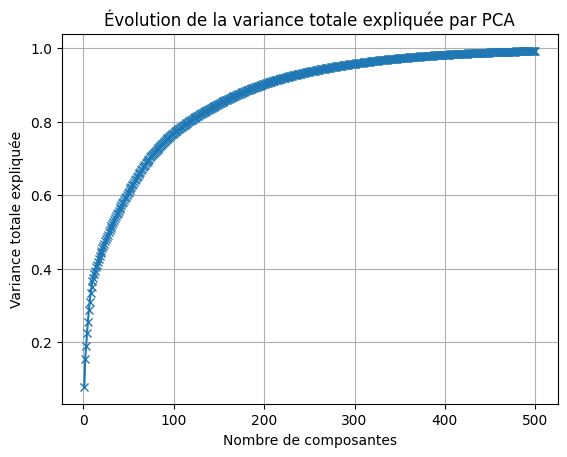

In [46]:
variance_expliquee = pca.explained_variance_ratio_
variance_cumulative = np.cumsum(variance_expliquee)

plt.plot(range(1, len(variance_cumulative) + 1), variance_cumulative, marker='x', linestyle='-')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance totale expliquée')
plt.title('Évolution de la variance totale expliquée par PCA')
plt.grid(True)
plt.show()

### Auto-encoding

In [59]:
# Defining the autoencoder architecture
input_dim = len(X_train.columns)
encoding_dim = 32
X_val = X_train.sample(frac = 0.2)
X_train_sample = X_train.drop(X_val.index)

input_layer = layers.Input(shape=(input_dim,))
encoder = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = models.Model(input_layer, decoder)

# Compiling the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, shuffle=True, validation_data=(X_test, X_test))

# Using the autoencoder to encode the data
encoded_data = encoder.predict(X_test)

NameError: name 'layers' is not defined